# Домашнее задание
Использование Facial Landmarks в качестве Feature Estimator

**Цель:**
В этом ДЗ вы создадите свой пайплайн Facial Recognition.


**Описание/Пошаговая инструкция выполнения домашнего задания:**
- Выберите Facial Detector по вкусу.
- Выполните Face Alignment.
- На это натравите Facial Landmarks Detector по выбору.
- На этом обучите классификатор на предпочитаемом датасете.

Для решения воспользуюсь датасетом со знаменитостями из Kaggle https://www.kaggle.com/datasets/vasukipatel/face-recognition-dataset

Оригинальные фотографии раслржены по папкам с именем знаменитости. Сперва соберу все фото в одну папку и добавлю аугментацию.

In [1]:
import matplotlib.pyplot as plt
import cv2 as cv
import os
import numpy as np
import face_alignment
from skimage import io
import math
import pandas as pd
from os import listdir
from os.path import join
import torch
from tqdm.notebook import tqdm

In [2]:
# if not os.path.exists("original"):
#         os.makedirs("original")
# for folder in os.listdir("Original Images"):
#     for image in os.listdir("Original Images" + "/" + folder):
#         full_path = os.path.join("Original Images", folder, image)
#         img = cv.imread(full_path)
#         cv.imwrite(f"original\{image}", img)

In [3]:
from sklearn.model_selection import train_test_split

list_of_files = os.listdir("original")
X_train, X_test = train_test_split(
    list_of_files, test_size=0.2, random_state=202
)

В это раз сделаю дополнительный шаг в пайплайне - выравнивание лиц - и сравню результаты при наличии этого шага и без него. Для этого добавлю функцию align_face

In [4]:
def align_face(image, landmarks):
    left_eye = landmarks[36:42].mean(axis=0)
    right_eye = landmarks[42:48].mean(axis=0)

    dY = right_eye[1] - left_eye[1]
    dX = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dY, dX))

    eyes_center = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)
    rotation_matrix = cv.getRotationMatrix2D(eyes_center, angle, 1.0)
    aligned_image = cv.warpAffine(
        image, rotation_matrix, (image.shape[1], image.shape[0])
    )

    return aligned_image

In [5]:
fa = face_alignment.FaceAlignment(
    face_alignment.LandmarksType.THREE_D,
    flip_input=False,
    device="cuda",
    dtype=torch.bfloat16,
    face_detector="blazeface",
    face_detector_kwargs={"back_model": True},
)

In [6]:
def augment_data(file_list, purpose, face_alignment_model, align = False, augment = False):
    PATH = f"{purpose}_faces"
    if not os.path.exists(PATH):
        os.makedirs(PATH)
    for filename in tqdm(file_list):
        full_path = join("original", filename)
        img = cv.imread(full_path, cv.IMREAD_GRAYSCALE)
        label = filename.split(".")[0]

        if align:
            try: 
                inp = io.imread(full_path)
                preds = face_alignment_model.get_landmarks(inp)[0]
                aligned_image = align_face(img, preds)
            except:
                aligned_image = img.copy()
        else:
            aligned_image = img.copy()

        if augment:
            img_flipped = cv.flip(aligned_image, 1)
            rows, cols = img.shape
            M1 = cv.getRotationMatrix2D((cols / 2, rows / 2), -30, 1)
            img_rotate30 = cv.warpAffine(aligned_image, M1, (cols, rows))
            M2 = cv.getRotationMatrix2D((cols / 2, rows / 2), -15, 1)
            img_rotate15 = cv.warpAffine(aligned_image, M2, (cols, rows))
            M3 = cv.getRotationMatrix2D((cols / 2, rows / 2), 30, 1)
            img_rotate30_2 = cv.warpAffine(aligned_image, M3, (cols, rows))
            M4 = cv.getRotationMatrix2D((cols / 2, rows / 2), 15, 1)
            img_rotate15_2 = cv.warpAffine(aligned_image, M4, (cols, rows))
            cv.imwrite(f"{purpose}_faces\{label}.jpeg", aligned_image)
            cv.imwrite(f"{purpose}_faces\{label}-flipped.jpeg", img_flipped)
            cv.imwrite(f"{purpose}_faces\{label}-rotated30.jpeg", img_rotate30)
            cv.imwrite(f"{purpose}_faces\{label}-rotated15.jpeg", img_rotate15)
            cv.imwrite(f"{purpose}_faces\{label}-rotated30_2.jpeg", img_rotate30_2)
            cv.imwrite(f"{purpose}_faces\{label}-rotated15_2.jpeg", img_rotate15_2)

        else:
            cv.imwrite(f"{purpose}_faces\{label}.jpeg", aligned_image)

In [7]:
import shutil

try:
    shutil.rmtree("test_faces")
    shutil.rmtree("train_faces")
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

В первом варианте выберу только аугментацию данных, но без выравнивания лиц

In [8]:
augment_data(X_train, 'train', fa, augment=True)
augment_data(X_test, 'test', fa)


  0%|          | 0/2049 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

In [9]:
def view_random_images(cols, rows, path_to_images, fa, landmarks = False):
    fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1), layout = 'tight')
    images = os.listdir(path_to_images)
    for i in range(cols):
        for j in range(rows):
            random_index = np.random.randint(0, len(images))
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid("off")
            ax.axis("off")
            img = cv.imread(os.path.join(path_to_images, images[random_index]))
            ax.imshow(img[..., ::-1])
            plt.title(images[random_index].split('.')[0], fontsize=10)
            if landmarks:
                inp = io.imread(os.path.join(path_to_images, images[random_index]))
                try:
                    preds = fa.get_landmarks(inp)[0]
                    plt.scatter(preds[:, 0], preds[:, 1], s=3, color="y")
                except:
                    pass

    plt.show()

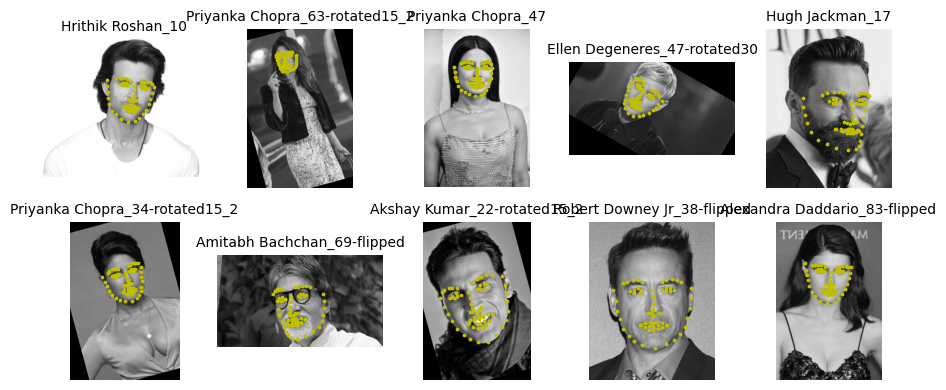

In [10]:
view_random_images(5, 2 , 'train_faces', fa, True)

Для определения индексов по лицу, выделю точки из 68-точечного полотна лицевых меток, которые будут использованы для расчета расстояния между ними и отдельной лицевой характеристики. Номера точек соберу в словарь lines_dict.

In [11]:
lines_dict = {
    "face_width": [15, 1],
    "face_length": [27, 8],
    "eyes_dist_inter": [42, 39],
    "eyes_dist_exter": [45, 36],
    "nose_width": [35, 31],
    "nose_len": [30, 27],
    "nose_side": [33, 27],
    "chin_to_nose": [27, 8],
    "lip_width": [57, 51],
    "lip_len": [54, 48],
    "upper_lip": [66, 51],
    "low_lip": [62, 57],
    "mouth_width": [48, 54],
    "mouth_len": [36, 45],
    "chin_width": [8, 57],
}

На одном из фото отрисую эти линии

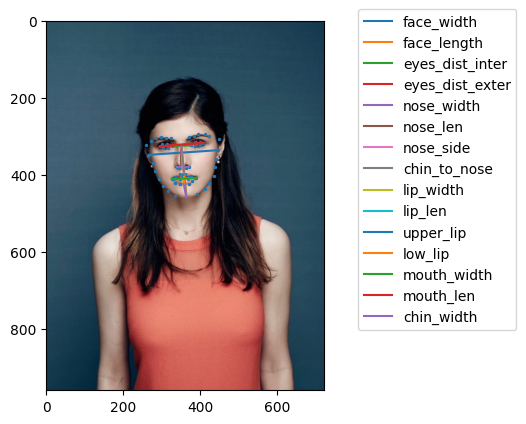

In [12]:
inp = io.imread("original\Alexandra Daddario_1.jpg")
preds = fa.get_landmarks(inp)[0]

plt.imshow(inp)
plt.scatter(
    preds[:, 0],
    preds[:, 1],
    s=2
)
for k, v in lines_dict.items():
    plt.plot(
        [preds[v][0][0], preds[v][1][0]], [preds[v][0][1], preds[v][1][1]], label=k
    )
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

indec_calc - вспомогательная функция для расчета индексов на основе расстояний, выбранных выше

In [13]:
def index_calc(coord, numerator_name, denominator_name):
    ind = (
        math.dist(
            coord[lines_dict[numerator_name][0]], coord[lines_dict[numerator_name][1]]
        )
        / math.dist(
            coord[lines_dict[denominator_name][0]],
            coord[lines_dict[denominator_name][1]],
        )
    ) * 100

    return ind

Итак, все фичи из train и test буду собирать в один датафрейм с помощью функции extract_features. В ней как раз видно как рассчитываются индексы.

In [14]:
from tqdm.notebook import tqdm

def extract_features(path_to_images, face_alignment_model):
    features = pd.DataFrame()
    for filename in tqdm(listdir(path_to_images)):
        full_path = join(path_to_images, filename)
        label = filename.split(".")[0]
        label = filename.split("_")[0]
        inp = io.imread(full_path)

        try:
            preds = face_alignment_model.get_landmarks(inp)[0]

            new_line = {
                "label": label,
                "facial_index": index_calc(preds, "face_length", "face_width"),
                "inter_canthial_index": index_calc(preds, "eyes_dist_inter", "eyes_dist_exter"),
                "nasal_index": index_calc(preds, "nose_width", "nose_len"),
                "naso_facial_index": index_calc(preds, "nose_side", "face_length"),
                "naso_facial_width_index": index_calc(preds, "nose_width", "face_width"),
                "lip_index": index_calc(preds, "lip_width", "lip_len"),
                "mouth_height_index": index_calc(preds, "lip_width", "face_length"),
                "upper_lip_thikness_index": index_calc(preds, "upper_lip", "lip_width"),
                "lower_lip_thikness_index": index_calc(preds, "low_lip", "lip_width"),
                "mouth_width_index": index_calc(preds, "mouth_width", "mouth_len"),
                "chin_size_index": index_calc(preds, "chin_width", "face_length"),
            }
        except:
            new_line = {
                "label": label,
                "facial_index": 0,
                "inter_canthial_index": 0,
                "nasal_index": 0,
                "naso_facial_index": 0,
                "naso_facial_width_index": 0,
                "lip_index": 0,
                "mouth_height_index": 0,
                "upper_lip_thikness_index": 0,
                "lower_lip_thikness_index": 0,
                "mouth_width_index": 0,
                "chin_size_index": 0,
            }
        features = pd.concat([features, pd.DataFrame([new_line])], ignore_index=True)

    return features

In [15]:
features_train = extract_features('train_faces', fa)
features_test = extract_features("test_faces", fa)

  0%|          | 0/12294 [00:00<?, ?it/s]

c:\Users\Kate\Desktop\absa_for_tests\.venv\Lib\site-packages\face_alignment\api.py:147: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")


  0%|          | 0/513 [00:00<?, ?it/s]

c:\Users\Kate\Desktop\absa_for_tests\.venv\Lib\site-packages\face_alignment\api.py:147: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")


Посмотрим, на примере 3-х людей, насколько отличается по каждому из них распределение индексов в обучающей выборке.

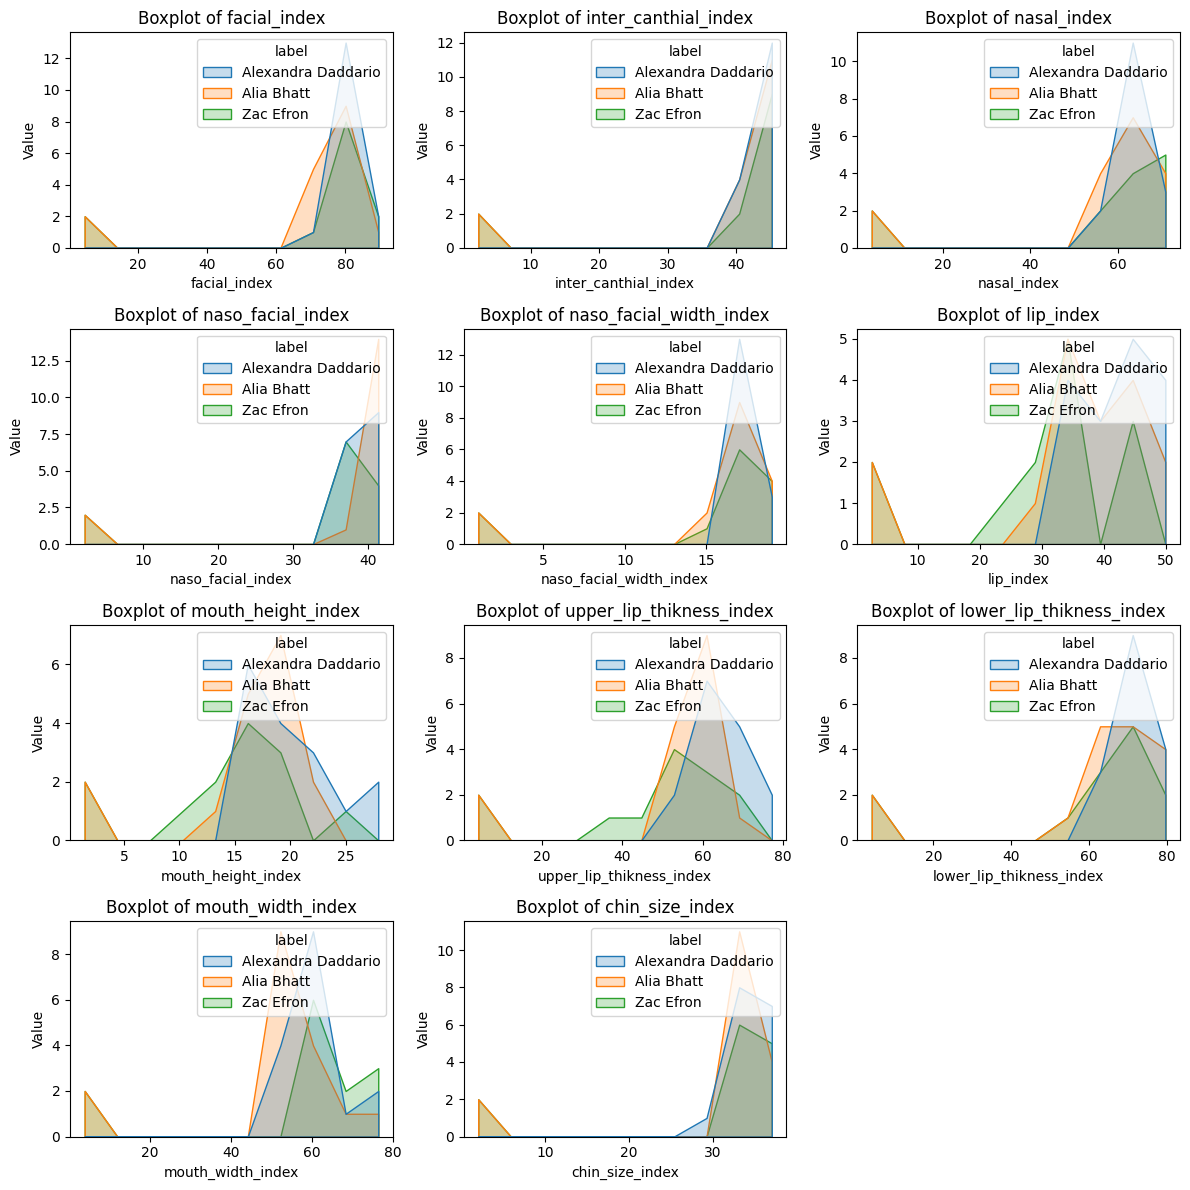

In [16]:
import seaborn as sns
def plot_features_distr(features_train):
    df_to_visualize = features_train
    df_to_visualize = df_to_visualize[
        df_to_visualize["label"].isin(["Zac Efron", "Alia Bhatt", "Alexandra Daddario"])
    ]
    features_list = list(df_to_visualize.columns.values)
    features_list.remove("label")
    plt.figure(figsize=(12, 12))
    for i, feature in enumerate(features_list):
        if feature != "label":
            plt.subplot(4, 3, i + 1)
            sns.histplot(
                x=df_to_visualize[feature],
                data=df_to_visualize,
                hue="label",
                bins=10,
                element="poly",
            )
            plt.title(f"Boxplot of {feature}")
            plt.xlabel(feature)
            plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

plot_features_distr(features_test)

Печально, но идексы не сильно отличаются. Начинают появляться плохие предчувствия :(

Подготовлю функцию для обучения классификатора на основе индексов, дополнительно посчитаю f1 по каждому классу в формате One vs All, чтобы понять как модель справляется с классификацией каждого отдельного человека. Дополнительно отрисую ROC curve для каждого класса

In [17]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_curve,
    auc,
)


def prepare_data_train(features_train, features_test):
    temp = pd.concat([features_train, features_test])
    data_classes = list(set(temp["label"].tolist()))

    features_train["labels_numeric"] = features_train["label"].apply(data_classes.index)
    features_test["labels_numeric"] = features_test["label"].apply(data_classes.index)
    features_train = features_train[features_train["facial_index"] != 0]
    features_test = features_test[features_test["facial_index"] != 0]
    Y_train = features_train["labels_numeric"]
    X_train = features_train.drop(["label", "labels_numeric"], axis=1)

    Y_test = features_test["labels_numeric"]
    X_test = features_test.drop(["label", "labels_numeric"], axis=1)
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    regressor = CatBoostClassifier(verbose=False)

    regressor.fit(X_train, Y_train)
    y_pred = regressor.predict(X_test)

    print(f"All classes Accuracy: {round(accuracy_score(Y_test, y_pred), 4)}")
    print(f"All classes F1: {round(f1_score(Y_test, y_pred, average='macro'), 4)}")
    print(f"All classes Recall: {round(recall_score(Y_test, y_pred, average='macro'), 4)}")
    print(f"All classes Precision: {round(precision_score(Y_test, y_pred, average='macro'), 4)}")

    label_binarizer = LabelBinarizer().fit(Y_train)
    y_onehot_test = label_binarizer.transform(Y_test)
    n_classes = y_onehot_test.shape[1]
    y_onehot_pred = label_binarizer.transform(y_pred)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    f1 = dict()
    lw = 2
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_onehot_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        f1[i] = f1_score(y_onehot_test[:, i], y_onehot_pred[:, i])
    for i in range(n_classes):
        plt.plot(
            fpr[i],
            tpr[i],
            lw=2,
            label="ROC class {0} (area = {1:0.2f}, f1 = {2:0.2f})"
            "".format(data_classes[i], roc_auc[i], f1[i]),
        )
    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC ONE vs ALL")
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

Попробую обучить классификатор

All classes Accuracy: 0.369
All classes F1: 0.3527
All classes Recall: 0.3603
All classes Precision: 0.3577


c:\Users\Kate\Desktop\absa_for_tests\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


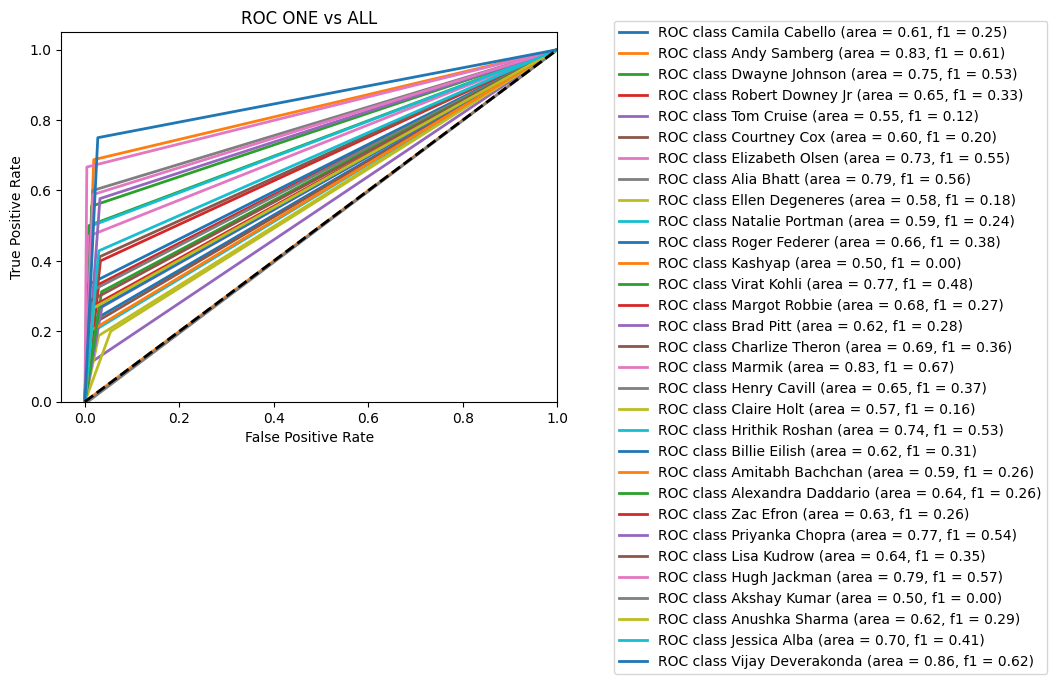

In [18]:
prepare_data_train(features_train, features_test)

В целом классификатор плохо справляется с классификацией на основе индексов лиц. Интересно, что очень многое зависит от качества подобранных фотографий: некоторых медийных персон получается неплохо определять. Например, Vijay Deverakonda - f1 = 62%. При этом актера Akshay Kumar вообще не получилось найти. ROC curve показывает, что большинство классификаци1 не совсем случайны :). Только для 2-х классов данная кривая совпала со случайной.

Теперь попробую добавить выравнивание лиц и проделаю те же самые шаги

In [19]:
import shutil

try:
    shutil.rmtree("test_faces")
    shutil.rmtree("train_faces")
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))


In [20]:
augment_data(X_train, "train",fa,  align=True, augment=True)
augment_data(X_test, "test", fa, align=True)

  0%|          | 0/2049 [00:00<?, ?it/s]

c:\Users\Kate\Desktop\absa_for_tests\.venv\Lib\site-packages\face_alignment\api.py:147: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")


  0%|          | 0/513 [00:00<?, ?it/s]

In [21]:
features_train2 = extract_features("train_faces", fa)
features_test2 = extract_features("test_faces", fa)

  0%|          | 0/12294 [00:00<?, ?it/s]

c:\Users\Kate\Desktop\absa_for_tests\.venv\Lib\site-packages\face_alignment\api.py:147: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")


  0%|          | 0/513 [00:00<?, ?it/s]

c:\Users\Kate\Desktop\absa_for_tests\.venv\Lib\site-packages\face_alignment\api.py:147: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")


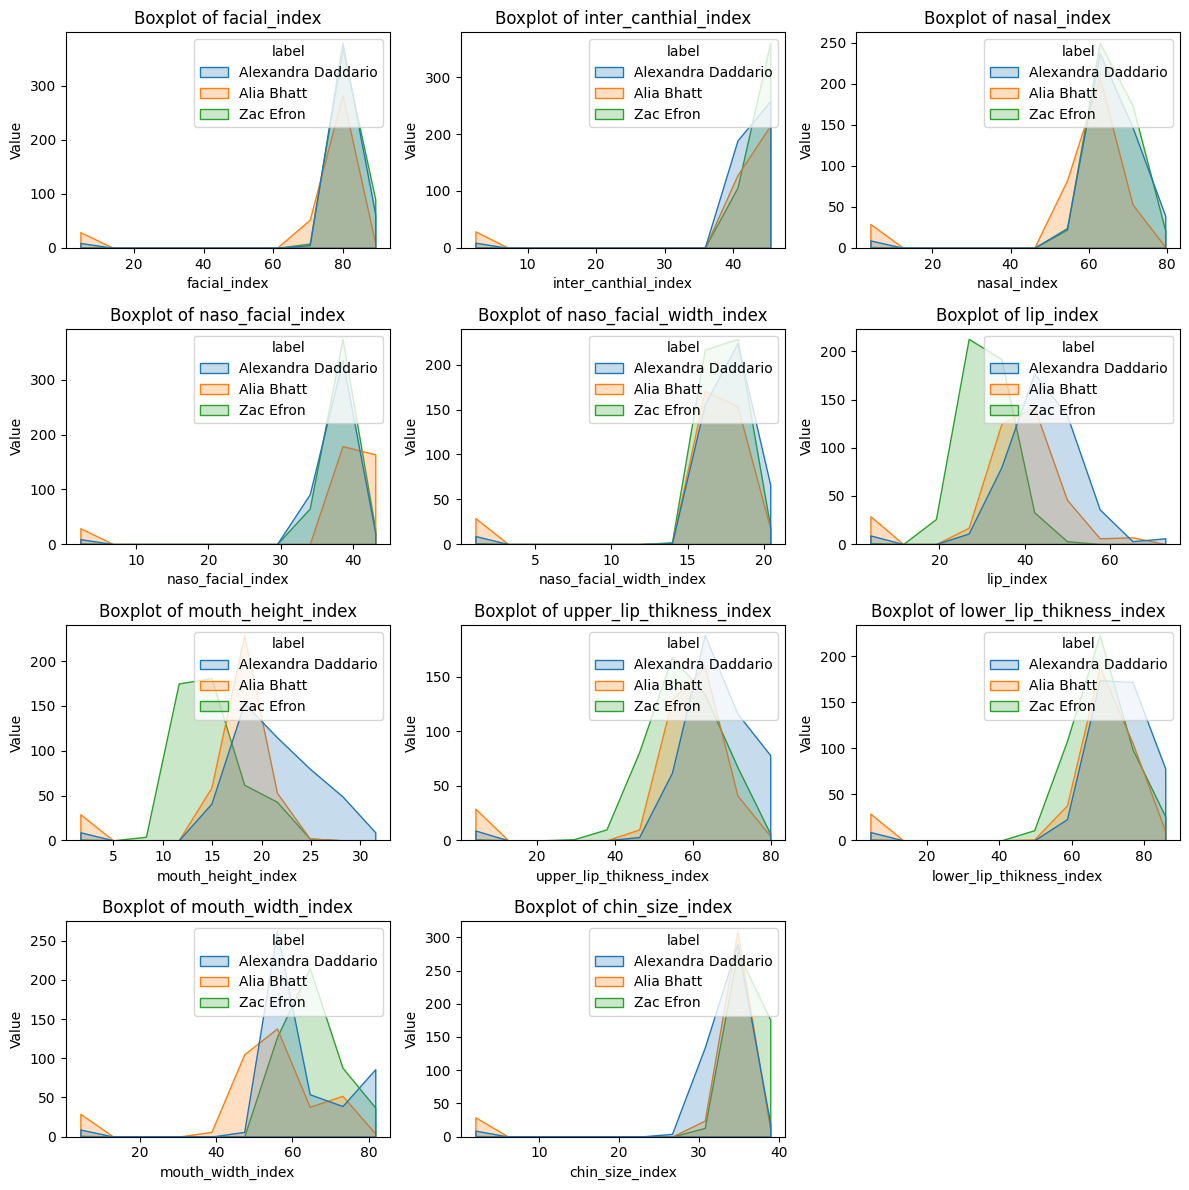

In [22]:
plot_features_distr(features_train2)

All classes Accuracy: 0.4105
All classes F1: 0.375
All classes Recall: 0.3898
All classes Precision: 0.3764


c:\Users\Kate\Desktop\absa_for_tests\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


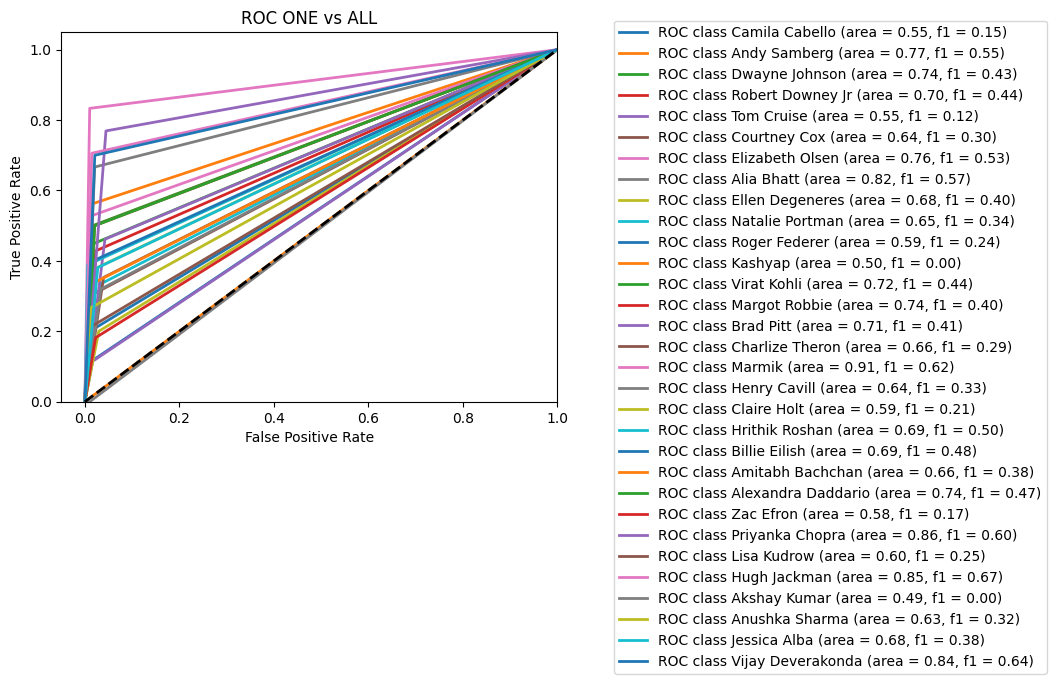

In [23]:
prepare_data_train(features_train2, features_test2)

Интересно, что качество классификации в целом немного улучшилась (F1 правда на 2% всего). Интересно, что немного поменялось качество и для каждого отдельного класса. Например, для Alia Bhatt качество ухудшилось: f1 упала с 73% до 58%. 

Посмотрим на фотографии, которые дают лучший результат и худший

In [24]:
def plot_images(cols, rows, path_to_images):
    fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1), layout = 'tight')
    images = os.listdir(path_to_images)
    for i in range(cols):
        for j in range(rows):
            random_index = np.random.randint(0, len(images))
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid("off")
            ax.axis("off")
            img = cv.imread(os.path.join(path_to_images, images[random_index]))
            ax.imshow(img[..., ::-1])
            plt.title(images[random_index].split('.')[0], fontsize=10)
    plt.show()

Примеры фотографий, где классификатор на основании индексов дает луший резельтат

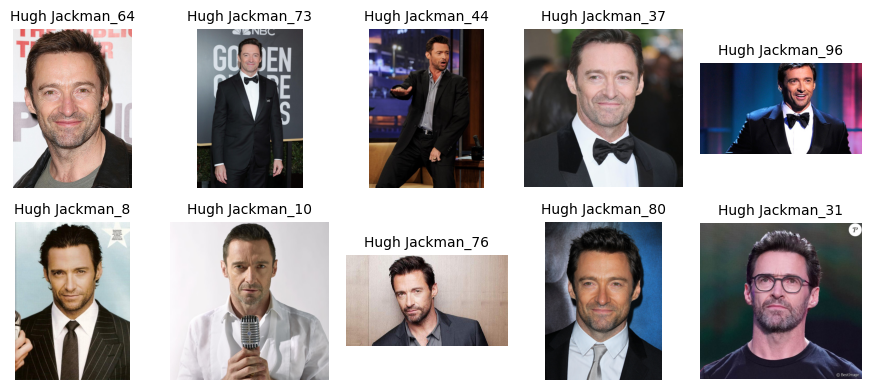

In [33]:
plot_images(5,2, 'Original Images/Hugh Jackman')

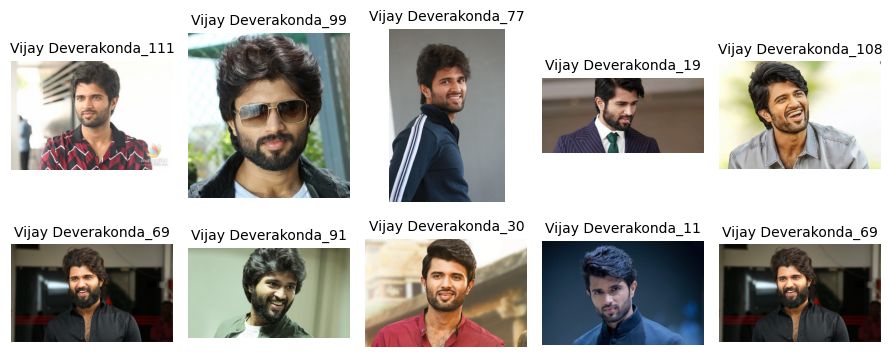

In [34]:
plot_images(5, 2, "Original Images/Vijay Deverakonda")

Примеры фотографий, где классификатор на основании индексов не справляется

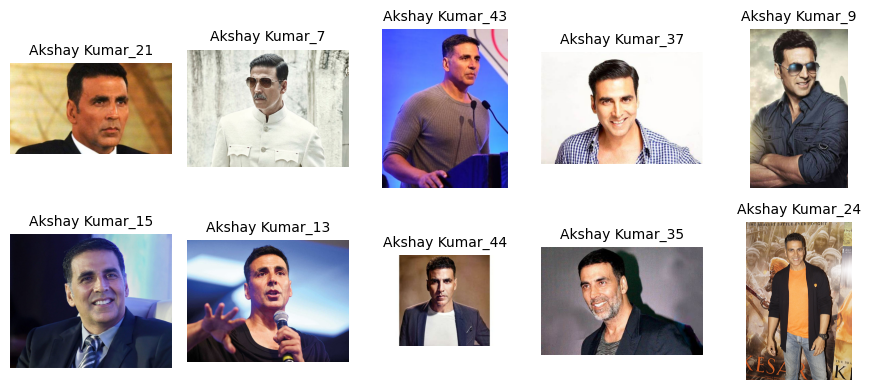

In [29]:
plot_images(5, 2, "Original Images/Akshay Kumar")

# Выводы

Получается, что классификация людей на основании индексов не совсем удачный подход и работает в том случае, если большинство ракурсов в обучающей и тестовой выборках похожие. Как например у Hugh Jackman. Изображения Akshay Kumar все очень разные и классификация на основе индексов не работает.